<a href="https://colab.research.google.com/github/Alfredo-GL-Franco/Analysis-of-avocado-ripening-with-spectroscopy-using-NIR-and-applying-machine-learning-techniques.-/blob/main/EDA_PALTA_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **Este codigo es el esquema 2 de EDA sobre el estado de maduracion de la palta utilizando NIR Y %DMC **
ESQUEMA CON MSC



En esta primera etapa vamos a recorrer toda la carpeta de la variedad fuerte para generar un solo dataframe con el consolidado de todos los espectros.

In [ ]:
import os
import pandas as pd
import re
from pathlib import Path


import numpy as np
from typing import List, Dict, Tuple, Optional
import logging
from google.colab import drive

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SpectralDataConsolidator:
    """
    Consolida archivos Excel de espectros en un DataFrame único y ordenado
    Optimizado para estructura: 1 archivo por punto (muestra-punto)
    """

    def __init__(self, carpeta_base: str, skip_rows: int = 5):
        self.carpeta_base = Path(carpeta_base)
        self.skip_rows = skip_rows
        self.archivos_procesados = []
        self.archivos_fallidos = []

    def extraer_metadatos_archivo(self, nombre_archivo: str) -> Dict[str, any]:
        """
        Extrae metadatos del nombre del archivo
        Patrones soportados: m1f-A, m01-B, muestra1_puntoA, etc.
        """
        metadatos = {
            'muestra': None,
            'punto': None,
            'archivo_original': nombre_archivo
        }

        # Patrón principal: m{número}f?-?{letra}
        patron1 = re.search(r'm(\d+)f?-?([A-D])', nombre_archivo, re.IGNORECASE)
        if patron1:
            metadatos['muestra'] = int(patron1.group(1))
            metadatos['punto'] = patron1.group(2).upper()
            return metadatos

        # Patrón alternativo: muestra{número}_punto{letra}
        patron2 = re.search(r'muestra(\d+).*punto([A-D])', nombre_archivo, re.IGNORECASE)
        if patron2:
            metadatos['muestra'] = int(patron2.group(1))
            metadatos['punto'] = patron2.group(2).upper()
            return metadatos

        # Patrón numérico: {número}-{letra}
        patron3 = re.search(r'(\d+)-([A-D])', nombre_archivo, re.IGNORECASE)
        if patron3:
            metadatos['muestra'] = int(patron3.group(1))
            metadatos['punto'] = patron3.group(2).upper()
            return metadatos

        logger.warning(f"No se pudieron extraer metadatos de: {nombre_archivo}")
        return metadatos

    def procesar_archivo_excel(self, ruta_archivo: Path) -> Optional[pd.DataFrame]:
        """
        Procesa un archivo Excel individual
        """
        try:
            logger.info(f"Procesando: {ruta_archivo.name}")

            # Leer archivo Excel
            df = pd.read_excel(ruta_archivo, skiprows=self.skip_rows)

            if df.empty:
                logger.warning(f"Archivo vacío: {ruta_archivo.name}")
                return None

            # Renombrar primera columna como wavelength
            df = df.rename(columns={df.columns[0]: 'wavelength'})

            # Eliminar columnas completamente vacías
            df = df.dropna(axis=1, how='all')

            # Eliminar filas con wavelength NaN
            df = df.dropna(subset=['wavelength'])

            # Extraer metadatos del nombre del archivo
            metadatos = self.extraer_metadatos_archivo(ruta_archivo.name)

            # Identificar columnas de espectros (numéricas, no wavelength)
            columnas_espectro = [col for col in df.columns
                               if col != 'wavelength' and pd.api.types.is_numeric_dtype(df[col])]

            if not columnas_espectro:
                logger.warning(f"No se encontraron columnas de espectro en: {ruta_archivo.name}")
                return None

            # Reestructurar datos: de formato ancho a largo
            # Cada fila será: wavelength, intensidad, muestra, punto, medicion_id
            datos_largos = []

            for i, col_espectro in enumerate(columnas_espectro):
                df_temp = df[['wavelength', col_espectro]].copy()
                df_temp = df_temp.dropna()  # Eliminar NaN en espectro

                # Agregar metadatos
                df_temp['muestra'] = metadatos['muestra']
                df_temp['punto'] = metadatos['punto']
                df_temp['medicion_id'] = i + 1  # ID de medición dentro del punto
                df_temp['archivo_original'] = metadatos['archivo_original']

                # Renombrar columna de intensidad
                df_temp = df_temp.rename(columns={col_espectro: 'intensidad'})

                datos_largos.append(df_temp)

            # Concatenar todas las mediciones del archivo
            if datos_largos:
                df_final = pd.concat(datos_largos, ignore_index=True)

                # Crear ID único para cada espectro
                df_final['espectro_id'] = (
                    df_final['muestra'].astype(str) + '_' +
                    df_final['punto'] + '_' +
                    df_final['medicion_id'].astype(str)
                )

                logger.info(f"✅ Procesado {ruta_archivo.name}: {len(columnas_espectro)} espectros, {len(df_final)} puntos espectrales")
                self.archivos_procesados.append(ruta_archivo.name)
                return df_final

        except Exception as e:
            logger.error(f"❌ Error procesando {ruta_archivo.name}: {str(e)}")
            self.archivos_fallidos.append((ruta_archivo.name, str(e)))
            return None

    def consolidar_todos_archivos(self) -> pd.DataFrame:
        """
        Consolida todos los archivos Excel en un DataFrame único
        """
        logger.info(f"🔄 Iniciando consolidación en: {self.carpeta_base}")

        if not self.carpeta_base.exists():
            raise FileNotFoundError(f"Carpeta no existe: {self.carpeta_base}")

        # Encontrar todos los archivos Excel
        archivos_excel = list(self.carpeta_base.glob('*.xlsx')) + list(self.carpeta_base.glob('*.xls'))

        if not archivos_excel:
            logger.warning("No se encontraron archivos Excel")
            return pd.DataFrame()

        logger.info(f"📁 Encontrados {len(archivos_excel)} archivos Excel")

        # Procesar cada archivo
        dataframes = []
        for archivo in archivos_excel:
            df_procesado = self.procesar_archivo_excel(archivo)
            if df_procesado is not None:
                dataframes.append(df_procesado)

        # Consolidar todos los DataFrames
        if dataframes:
            df_consolidado = pd.concat(dataframes, ignore_index=True)

            # Ordenar datos
            df_consolidado = df_consolidado.sort_values([
                'muestra', 'punto', 'medicion_id', 'wavelength'
            ]).reset_index(drop=True)

            logger.info(f"✅ Consolidación completada:")
            logger.info(f"   • Total espectros individuales: {df_consolidado['espectro_id'].nunique()}")
            logger.info(f"   • Total puntos espectrales: {len(df_consolidado)}")
            logger.info(f"   • Muestras: {df_consolidado['muestra'].nunique()}")
            logger.info(f"   • Puntos por muestra: {df_consolidado['punto'].nunique()}")
            logger.info(f"   • Rango wavelength: {df_consolidado['wavelength'].min():.1f} - {df_consolidado['wavelength'].max():.1f}")

            return df_consolidado

        else:
            logger.error("❌ No se pudieron procesar archivos")
            return pd.DataFrame()

    def convertir_a_formato_ancho(self, df_largo: pd.DataFrame) -> pd.DataFrame:
        """
        Convierte formato largo a ancho para análisis ML
        Cada fila = un espectro completo
        """
        logger.info("🔄 Convirtiendo a formato ancho para ML...")

        # Crear tabla pivote
        df_ancho = df_largo.pivot_table(
            index=['espectro_id', 'muestra', 'punto', 'medicion_id', 'archivo_original'],
            columns='wavelength',
            values='intensidad',
            aggfunc='mean'  # En caso de duplicados
        ).reset_index()

        # Aplanar nombres de columnas
        df_ancho.columns.name = None
        wavelength_cols = [col for col in df_ancho.columns if isinstance(col, (int, float))]
        df_ancho = df_ancho.rename(columns={col: f'wl_{col}' for col in wavelength_cols})

        logger.info(f"✅ Formato ancho creado: {df_ancho.shape[0]} espectros × {len(wavelength_cols)} wavelengths")

        return df_ancho

    def generar_reporte_consolidacion(self, df: pd.DataFrame) -> Dict:
        """
        Genera reporte detallado de la consolidación
        """
        if df.empty:
            return {"error": "DataFrame vacío"}

        # Análisis por muestra y punto
        resumen_por_punto = df.groupby(['muestra', 'punto']).agg({
            'espectro_id': 'nunique',
            'wavelength': ['min', 'max', 'nunique'],
            'intensidad': ['mean', 'std']
        }).round(3)

        reporte = {
            "resumen_general": {
                "total_espectros": df['espectro_id'].nunique(),
                "total_puntos_espectrales": len(df),
                "muestras_unicas": df['muestra'].nunique(),
                "puntos_unicos": df['punto'].nunique(),
                "rango_wavelength": (df['wavelength'].min(), df['wavelength'].max()),
                "archivos_procesados": len(self.archivos_procesados),
                "archivos_fallidos": len(self.archivos_fallidos)
            },
            "distribucion_por_muestra": df.groupby('muestra')['espectro_id'].nunique().to_dict(),
            "distribucion_por_punto": df.groupby('punto')['espectro_id'].nunique().to_dict(),
            "resumen_por_punto": resumen_por_punto,
            "archivos_exitosos": self.archivos_procesados,
            "archivos_con_errores": self.archivos_fallidos
        }

        return reporte

    def guardar_datos_consolidados(self, df: pd.DataFrame, formato: str = 'parquet') -> str:
        """
        Guarda datos consolidados en formato eficiente
        """
        output_dir = self.carpeta_base / "datos_consolidados"
        output_dir.mkdir(exist_ok=True)

        if formato == 'parquet':
            archivo_salida = output_dir / "espectros_consolidados.parquet"
            df.to_parquet(archivo_salida, compression='snappy')
        elif formato == 'csv':
            archivo_salida = output_dir / "espectros_consolidados.csv"
            df.to_csv(archivo_salida, index=False)
        elif formato == 'excel':
            archivo_salida = output_dir / "espectros_consolidados.xlsx"
            df.to_excel(archivo_salida, index=False)

        logger.info(f"💾 Datos guardados en: {archivo_salida}")
        return str(archivo_salida)

def main():
    """
    Función principal - Ejemplo de uso
    """
    # Mount Google Drive
    drive.mount('/content/drive')

    # Configuración
    carpeta_datos = '/content/drive/MyDrive/Verano_delfin/Avance_data/NUEVA DATA/TESIS DATOS/TESIS DATOS/FUERTE'

    # Crear consolidador
    consolidador = SpectralDataConsolidator(carpeta_datos, skip_rows=5)

    # Consolidar archivos
    print("🚀 INICIANDO CONSOLIDACIÓN DE DATOS ESPECTRALES")
    print("=" * 60)

    df_consolidado = consolidador.consolidar_todos_archivos()

    if not df_consolidado.empty:
        # Generar reporte
        reporte = consolidador.generar_reporte_consolidacion(df_consolidado)

        print("\n📊 REPORTE DE CONSOLIDACIÓN:")
        print("-" * 40)
        for seccion, datos in reporte["resumen_general"].items():
            print(f"{seccion}: {datos}")

        print(f"\n📈 DISTRIBUCIÓN POR MUESTRA:")
        for muestra, count in reporte["distribucion_por_muestra"].items():
            print(f"   Muestra {muestra}: {count} espectros")

        print(f"\n📍 DISTRIBUCIÓN POR PUNTO:")
        for punto, count in reporte["distribucion_por_punto"].items():
            print(f"   Punto {punto}: {count} espectros")

        # Mostrar muestra de datos
        print(f"\n🔍 MUESTRA DE DATOS (primeras 5 filas):")
        print(df_consolidado.head())

        # Convertir a formato ancho para ML
        print(f"\n🔄 CONVIRTIENDO A FORMATO ANCHO PARA ML...")
        df_ancho = consolidador.convertir_a_formato_ancho(df_consolidado)

        print(f"\n📐 FORMATO ANCHO (ML-ready):")
        print(f"   Shape: {df_ancho.shape}")
        print(f"   Columnas: {list(df_ancho.columns[:10])}...")  # Primeras 10

        # Guardar datos
        archivo_guardado = consolidador.guardar_datos_consolidados(df_consolidado, formato='parquet')

        print(f"\n✅ CONSOLIDACIÓN COMPLETADA")
        print(f"📁 Datos guardados en: {archivo_guardado}")

        return df_consolidado, df_ancho

    else:
        print("❌ No se pudieron consolidar los datos")
        return None, None

if __name__ == "__main__":
    df_largo, df_ancho = main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 INICIANDO CONSOLIDACIÓN DE DATOS ESPECTRALES

📊 REPORTE DE CONSOLIDACIÓN:
----------------------------------------
total_espectros: 6535
total_puntos_espectrales: 1326605
muestras_unicas: 16
puntos_unicos: 4
rango_wavelength: (903.4703528544339, 1700.8300273203536)
archivos_procesados: 64
archivos_fallidos: 0

📈 DISTRIBUCIÓN POR MUESTRA:
   Muestra 1: 436 espectros
   Muestra 2: 400 espectros
   Muestra 3: 400 espectros
   Muestra 4: 499 espectros
   Muestra 5: 400 espectros
   Muestra 6: 400 espectros
   Muestra 7: 400 espectros
   Muestra 8: 400 espectros
   Muestra 9: 400 espectros
   Muestra 10: 400 espectros
   Muestra 11: 400 espectros
   Muestra 12: 400 espectros
   Muestra 13: 400 espectros
   Muestra 14: 400 espectros
   Muestra 15: 400 espectros
   Muestra 16: 400 espectros

📍 DISTRIBUCIÓN POR PUNTO:
   Punto A: 1636 espectros
   Punto B: 1600 esp

Separar los datos para train, test y validation

In [ ]:
from sklearn.model_selection import train_test_split
if df_ancho is not None and not df_ancho.empty:

    train_df, temp_df = train_test_split(df_ancho, test_size=0.40, random_state=42) # 40% para temp (validation + test)

    # Luego, separar el 20% restante (temp_df) en validation (50% de temp) y test (50% de temp)
    # Esto resulta en 20% validation y 20% test (50% de 40% = 20%)
    validation_df, test_df = train_test_split(temp_df, test_size=0.75, random_state=42)

    print(f"\n📊 Datos separados:")
    print(f"   Train (60%): {train_df.shape[0]} espectros")
    print(f"   Validation (10%): {validation_df.shape[0]} espectros")
    print(f"   Test (30%): {test_df.shape[0]} espectros")

    # Puedes mostrar una muestra de cada set si lo deseas
    # print("\nTrain sample:")
    # print(train_df.head())
    # print("\nValidation sample:")
    # print(validation_df.head())
    # print("\nTest sample:")
    # print(test_df.head())

else:
    print("\n❌ No se pudo realizar la separación de datos. df_ancho está vacío o es None.")


📊 Datos separados:
   Train (60%): 3921 espectros
   Validation (10%): 653 espectros
   Test (30%): 1961 espectros


Aplicar msc para disminuir la dispersion y el ruido

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def msc(input_data):
    """
    Perform Multiplicative Scatter Correction (MSC) on input_data.

    Parameters:
    input_data: numpy array or pandas DataFrame (samples x variables)
        The data to perform MSC on.

    Returns:
    msc_data: numpy array
        The MSC corrected data.
    mean_spectrum: numpy array
        The mean spectrum used for correction.
    """
    # Convertir a numpy array
    if isinstance(input_data, pd.DataFrame):
        input_data_np = input_data.values
    else:
        input_data_np = np.asarray(input_data)

    # Calcular la media del spectrum
    mean_spectrum = np.mean(input_data_np, axis=0)

    # Preparar el  array  MSC data
    msc_data = np.zeros_like(input_data_np)

    for i in range(input_data_np.shape[0]):
        # Fit a linear model (y = ax + b)

        X = np.vstack([mean_spectrum, np.ones(len(mean_spectrum))]).T
        y = input_data_np[i, :]

        # L salida es  [a, b]
        coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
        a, b = coeffs

        # Aplicar  la correccion: (current_spectrum - b) / a
        msc_data[i, :] = (input_data_np[i, :] - b) / a

    return msc_data, mean_spectrum




# Identificar  wavelength columns para aplicar MSC

wavelength_cols = [col for col in train_df.columns if col.startswith('wl_')]

if not wavelength_cols:
    print("\n❌ No se encontraron columnas de longitud de onda ('wl_') para aplicar MSC.")
else:
    # Extraer el spectral data de los DataFrames
    train_spectra = train_df[wavelength_cols]
    validation_spectra = validation_df[wavelength_cols]
    test_spectra = test_df[wavelength_cols]

    print("\n🔬 Aplicando Multiplicative Scatter Correction (MSC)...")

    # Aplicar MSC a la training data

    train_spectra_msc, mean_spectrum_train = msc(train_spectra)
    print(f"✅ MSC aplicado a train_df. Shape: {train_spectra_msc.shape}")

    # Aplicar MSC a la validation data usando la mean spectrum de el training data

    validation_spectra_msc = np.zeros_like(validation_spectra)
    X_val = np.vstack([mean_spectrum_train, np.ones(len(mean_spectrum_train))]).T
    for i in range(validation_spectra.shape[0]):
        y_val = validation_spectra.iloc[i, :].values
        coeffs_val, residuals_val, rank_val, s_val = np.linalg.lstsq(X_val, y_val, rcond=None)
        a_val, b_val = coeffs_val
        validation_spectra_msc[i, :] = (y_val - b_val) / a_val
    print(f"✅ MSC aplicado a validation_df. Shape: {validation_spectra_msc.shape}")


    # Aplicar MSC a el test data usando la mean spectrum de el training data

    test_spectra_msc = np.zeros_like(test_spectra)
    X_test = np.vstack([mean_spectrum_train, np.ones(len(mean_spectrum_train))]).T
    for i in range(test_spectra.shape[0]):
        y_test = test_spectra.iloc[i, :].values
        coeffs_test, residuals_test, rank_test, s_test = np.linalg.lstsq(X_test, y_test, rcond=None)
        a_test, b_test = coeffs_test
        test_spectra_msc[i, :] = (y_test - b_test) / a_test
    print(f"✅ MSC aplicado a test_df. Shape: {test_spectra_msc.shape}")

    # Reemplazar el spectral original columns con el  MSC data
    train_df_msc = train_df.copy()
    train_df_msc[wavelength_cols] = train_spectra_msc

    validation_df_msc = validation_df.copy()
    validation_df_msc[wavelength_cols] = validation_spectra_msc

    test_df_msc = test_df.copy()
    test_df_msc[wavelength_cols] = test_spectra_msc

    print("\n💾 DataFrames actualizados con espectros corregidos por MSC:")
    print(f"   train_df_msc.shape: {train_df_msc.shape}")
    print(f"   validation_df_msc.shape: {validation_df_msc.shape}")
    print(f"   test_df_msc.shape: {test_df_msc.shape}")




🔬 Aplicando Multiplicative Scatter Correction (MSC)...
✅ MSC aplicado a train_df. Shape: (3921, 203)
✅ MSC aplicado a validation_df. Shape: (653, 203)
✅ MSC aplicado a test_df. Shape: (1961, 203)

💾 DataFrames actualizados con espectros corregidos por MSC:
   train_df_msc.shape: (3921, 208)
   validation_df_msc.shape: (653, 208)
   test_df_msc.shape: (1961, 208)


# Aplicar la primera dervida del filtro savgol


In [ ]:
from scipy.signal import savgol_filter

# Definir los parametros Savitzky-Golay filter
window_length = 11  # debe ser menos al numero de puntos
polyorder = 3

# Identificar la wavelength columns de el MSC dataframes
wavelength_cols = [col for col in train_df_msc.columns if col.startswith('wl_')]

if not wavelength_cols:
    print("\n❌ No se encontraron columnas de longitud de onda ('wl_') para aplicar el filtro Savitzky-Golay.")
else:
    print("\n smoothing the data using Savitzky-Golay filter...")

    # Aplicar Savitzky-Golay filter a el spectral data en cada set
    train_spectra_sg = savgol_filter(train_df_msc[wavelength_cols], window_length, polyorder,deriv=2, axis=1)
    validation_spectra_sg = savgol_filter(validation_df_msc[wavelength_cols], window_length, polyorder,deriv=2, axis=1)
    test_spectra_sg = savgol_filter(test_df_msc[wavelength_cols], window_length, polyorder,deriv=2, axis=1)

    # Reemplazar el original spectral columns con la data filtrada
    train_df_sg = train_df_msc.copy()
    train_df_sg[wavelength_cols] = train_spectra_sg

    validation_df_sg = validation_df_msc.copy()
    validation_df_sg[wavelength_cols] = validation_spectra_sg

    test_df_sg = test_df_msc.copy()
    test_df_sg[wavelength_cols] = test_spectra_sg

    print(f"✅ Savitzky-Golay filter applied to train_df_msc. Shape: {train_df_sg.shape}")
    print(f"✅ Savitzky-Golay filter applied to validation_df_msc. Shape: {validation_df_sg.shape}")
    print(f"✅ Savitzky-Golay filter applied to test_df_msc. Shape: {test_df_sg.shape}")




 smoothing the data using Savitzky-Golay filter...
✅ Savitzky-Golay filter applied to train_df_msc. Shape: (3921, 208)
✅ Savitzky-Golay filter applied to validation_df_msc. Shape: (653, 208)
✅ Savitzky-Golay filter applied to test_df_msc. Shape: (1961, 208)


# Plotear los diferentes resultados del tratamiento de los datos

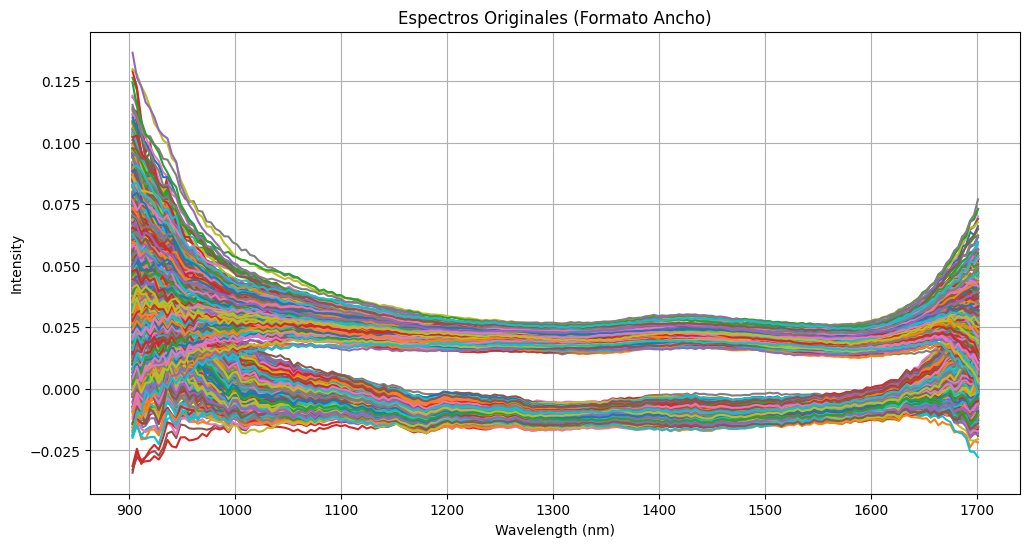

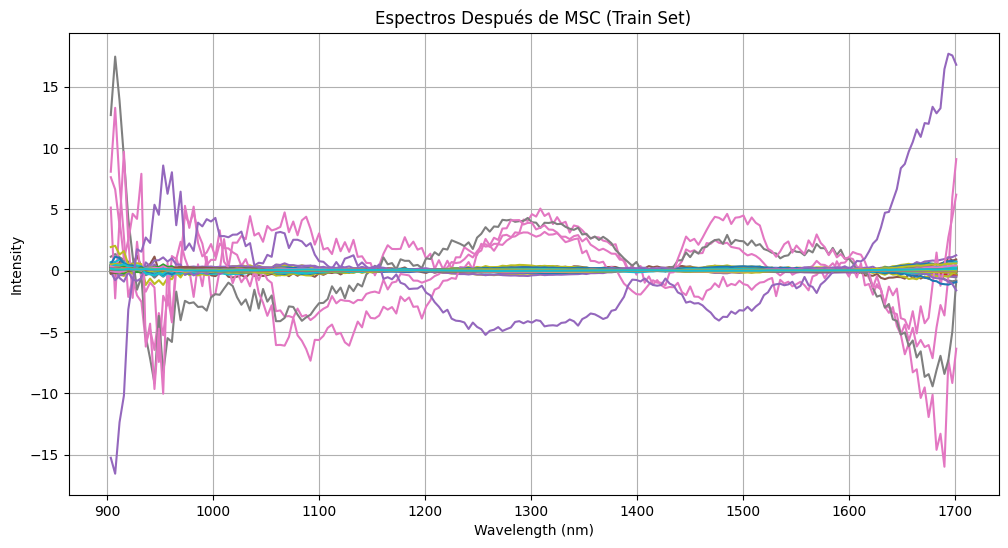

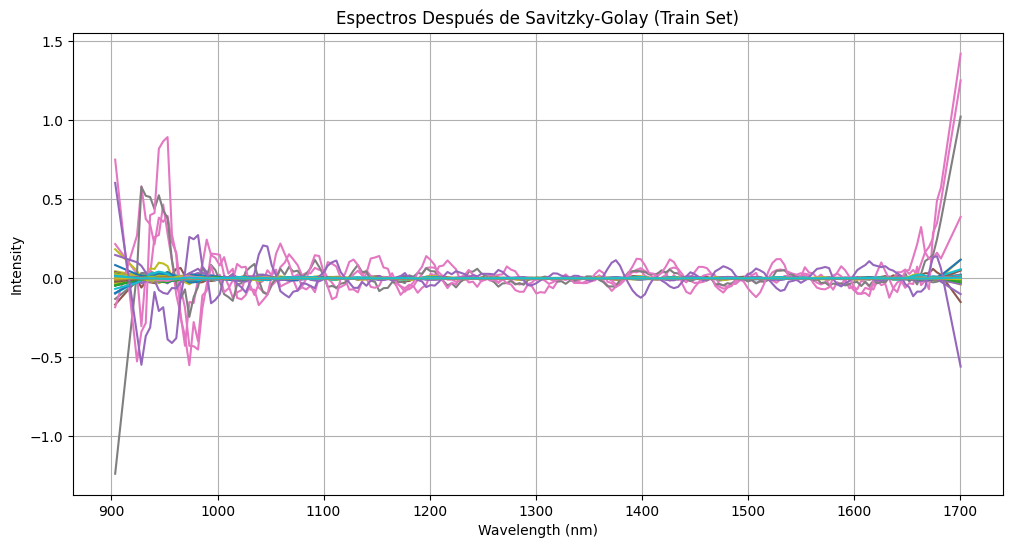

In [ ]:


import matplotlib.pyplot as plt

# Function para plottear el spectra
def plot_spectra(df, title, num_spectra=1000):
    """Escoger el numero de muestras a plottear."""
    wavelength_cols = [col for col in df.columns if col.startswith('wl_')]
    wavelengths = np.array([float(col.split('_')[1]) for col in wavelength_cols])

    plt.figure(figsize=(12, 6))
    for i in range(min(num_spectra, df.shape[0])):
        plt.plot(wavelengths, df.iloc[i][wavelength_cols], label=f'Espectro {i+1}')

    plt.title(title)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

# ---  antes de preprocesar ---
if df_ancho is not None and not df_ancho.empty:
    plot_spectra(df_ancho, 'Espectros Originales (Formato Ancho)')
else:
    print("No se pudo graficar: DataFrame original vacío.")

# --- Plottear despues MSC ---
if 'train_df_msc' in locals() and not train_df_msc.empty:
    plot_spectra(train_df_msc, 'Espectros Después de MSC (Train Set)')
else:
    print("No se pudo graficar: DataFrame después de MSC vacío.")

# --- Plottear despues Savitzky-Golay ---
if 'train_df_sg' in locals() and not train_df_sg.empty:
    plot_spectra(train_df_sg, 'Espectros Después de Savitzky-Golay (Train Set)')
else:
    print("No se pudo graficar: DataFrame después de Savitzky-Golay vacío.")

# Aplicar un recorte para eliminar el ruido de los extremos


✂️ Recortando espectros de df_ancho a 950-1650 nm...

✂️ Recortando espectros de train_df_sg a 950-1650 nm...

✂️ Recortando espectros de validation_df_sg a 950-1650 nm...

✂️ Recortando espectros de test_df_sg a 950-1650 nm...

📊 Información de df_ancho_recortado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Columns: 182 entries, espectro_id to wl_1648.5700412988667
dtypes: float64(177), int64(2), object(3)
memory usage: 9.1+ MB
None

📊 Información de train_df_sg_recortado:
<class 'pandas.core.frame.DataFrame'>
Index: 3921 entries, 2525 to 860
Columns: 182 entries, espectro_id to wl_1648.5700412988667
dtypes: float64(177), int64(2), object(3)
memory usage: 5.5+ MB
None


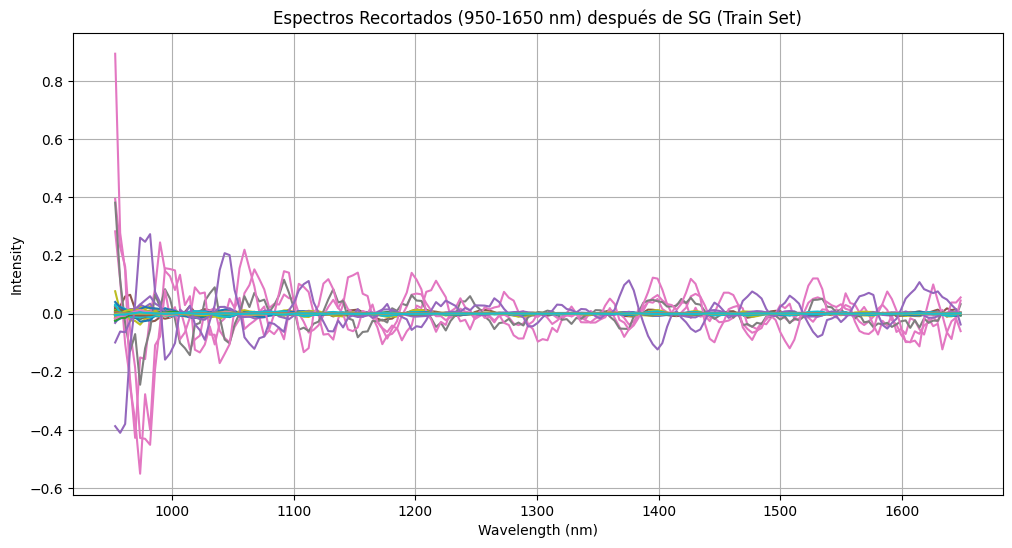

In [ ]:


def recortar_espectros(df, min_wl, max_wl):
    """
    Recorta las columnas de longitud de onda de un DataFrame a un rango específico.

    Parameters:
    df: pandas DataFrame
        El DataFrame con columnas de longitud de onda que comienzan con 'wl_'.
    min_wl: int or float
        La longitud de onda mínima a incluir.
    max_wl: int or float
        La longitud de onda máxima a incluir.

    Returns:
    df_recortado: pandas DataFrame
        El DataFrame con las columnas de longitud de onda recortadas.
    """
    wavelength_cols = [col for col in df.columns if col.startswith('wl_')]
    # Extraer los valores numéricos de las longitudes de onda
    wavelengths = np.array([float(col.split('_')[1]) for col in wavelength_cols])

    # Identificar las columnas que están dentro del rango especificado
    cols_to_keep = [col for col, wl in zip(wavelength_cols, wavelengths) if min_wl <= wl <= max_wl]

    # Asegurarse de mantener las columnas que no son de longitud de onda
    non_wavelength_cols = [col for col in df.columns if not col.startswith('wl_')]

    # Combinar las columnas no de longitud de onda y las columnas de longitud de onda recortadas
    all_cols_to_keep = non_wavelength_cols + cols_to_keep

    if not cols_to_keep:
        print(f"Advertencia: No se encontraron columnas de longitud de onda en el rango {min_wl}-{max_wl} nm.")
        # Devolver solo las columnas que no son de longitud de onda si no hay columnas de espectro en el rango
        return df[non_wavelength_cols]


    df_recortado = df[all_cols_to_keep].copy()
    logger.info(f"✅ Espectros recortados al rango {min_wl}-{max_wl} nm. Nuevo shape: {df_recortado.shape}")

    return df_recortado

# Definir el rango de longitud de onda para recortar
min_wavelength_to_keep = 950
max_wavelength_to_keep = 1650

# Aplicar el recorte a cada uno de los DataFrames (original, MSC, SG)
if 'df_ancho' in locals() and df_ancho is not None and not df_ancho.empty:
    print(f"\n✂️ Recortando espectros de df_ancho a {min_wavelength_to_keep}-{max_wavelength_to_keep} nm...")
    df_ancho_recortado = recortar_espectros(df_ancho, min_wavelength_to_keep, max_wavelength_to_keep)
else:
    print("\n❌ No se pudo recortar df_ancho: DataFrame original vacío.")
    df_ancho_recortado = None

if 'train_df_sg' in locals() and not train_df_sg.empty:
    print(f"\n✂️ Recortando espectros de train_df_sg a {min_wavelength_to_keep}-{max_wavelength_to_keep} nm...")
    train_df_sg_recortado = recortar_espectros(train_df_sg, min_wavelength_to_keep, max_wavelength_to_keep)
else:
    print("\n❌ No se pudo recortar train_df_sg: DataFrame después de Savitzky-Golay vacío.")
    train_df_sg_recortado = None

if 'validation_df_sg' in locals() and not validation_df_sg.empty:
    print(f"\n✂️ Recortando espectros de validation_df_sg a {min_wavelength_to_keep}-{max_wavelength_to_keep} nm...")
    validation_df_sg_recortado = recortar_espectros(validation_df_sg, min_wavelength_to_keep, max_wavelength_to_keep)
else:
    print("\n❌ No se pudo recortar validation_df_sg: DataFrame de validación después de Savitzky-Golay vacío.")
    validation_df_sg_recortado = None

if 'test_df_sg' in locals() and not test_df_sg.empty:
    print(f"\n✂️ Recortando espectros de test_df_sg a {min_wavelength_to_keep}-{max_wavelength_to_keep} nm...")
    test_df_sg_recortado = recortar_espectros(test_df_sg, min_wavelength_to_keep, max_wavelength_to_keep)
else:
    print("\n❌ No se pudo recortar test_df_sg: DataFrame de test después de Savitzky-Golay vacío.")
    test_df_sg_recortado = None


# Mostrar información sobre los DataFrames recortados (opcional)
if df_ancho_recortado is not None:
    print("\n📊 Información de df_ancho_recortado:")
    print(df_ancho_recortado.info())

if train_df_sg_recortado is not None:
    print("\n📊 Información de train_df_sg_recortado:")
    print(train_df_sg_recortado.info())

# Opcional: Graficar espectros recortados para verificar
if train_df_sg_recortado is not None and not train_df_sg_recortado.empty:
     plot_spectra(train_df_sg_recortado, f'Espectros Recortados ({min_wavelength_to_keep}-{max_wavelength_to_keep} nm) después de SG (Train Set)')
else:
     print("\nNo se pudo graficar los espectros recortados (train_df_sg_recortado vacío).")


# Aplicar PCA a todo los sets


 📊 Aplicando Principal Component Analysis (PCA) con escalado...
✅ PCA aplicado.
   Train PCA shape: (3921, 203)
   Validation PCA shape: (653, 203)
   Test PCA shape: (1961, 203)

📊 Explained Variance Ratio per Principal Component:
   PC 1: 0.4344
   PC 2: 0.2653
   PC 3: 0.0786
   PC 4: 0.0561
   PC 5: 0.0490
   PC 6: 0.0319
   PC 7: 0.0208
   PC 8: 0.0169
   PC 9: 0.0151
   PC 10: 0.0090

📈 Cumulative Explained Variance:
   Up to PC 1: 0.4344
   Up to PC 2: 0.6997
   Up to PC 3: 0.7783
   Up to PC 4: 0.8344
   Up to PC 5: 0.8834
   Up to PC 6: 0.9153
   Up to PC 7: 0.9361
   Up to PC 8: 0.9530
   Up to PC 9: 0.9681
   Up to PC 10: 0.9771


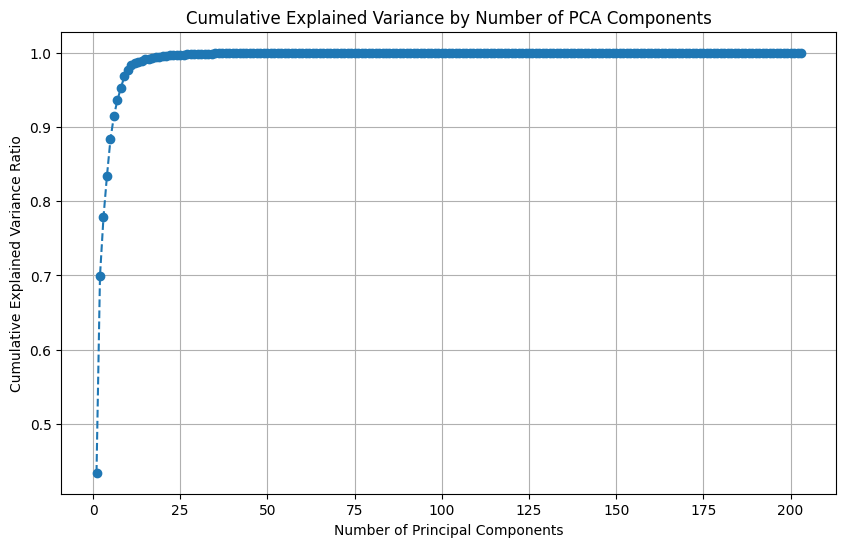


💡 Recommended number of components to retain ~95% variance: 8

💾 PCA results with 8 components:
   Train PCA final shape: (3921, 8)
   Validation PCA final shape: (653, 8)
   Test PCA final shape: (1961, 8)

💾 DataFrames actualizados con componentes PCA:
   train_df_pca.shape: (3921, 13)
   validation_df_pca.shape: (653, 13)
   test_df_pca.shape: (1961, 13)


In [ ]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


# Identificar el wavelength columns de el Savitzky-Golay dataframes filtrado
wavelength_cols_sg = [col for col in train_df_sg.columns if col.startswith('wl_')]

if not wavelength_cols_sg:
    print("\n❌ No se encontraron columnas de longitud de onda ('wl_') para aplicar PCA.")
else:
    print("\n 📊 Aplicando Principal Component Analysis (PCA) con escalado...") # Actualizar mensaje

    # Extraera el spectral data para PCA
    train_spectra_pca = train_df_sg[wavelength_cols_sg]
    validation_spectra_pca = validation_df_sg[wavelength_cols_sg]
    test_spectra_pca = test_df_sg[wavelength_cols_sg]

    # añadir scaling steps
    scaler = StandardScaler()

    # Fit el scaler en el training data
    scaler.fit(train_spectra_pca)

    # Transformar todos los sets usando  el scaler fitted en el training data
    train_spectra_scaled = scaler.transform(train_spectra_pca)
    validation_spectra_scaled = scaler.transform(validation_spectra_pca)
    test_spectra_scaled = scaler.transform(test_spectra_pca)

    # Inicializar PCA.

    pca = PCA()

    # Fit PCA en el scaled training data solamente
    pca.fit(train_spectra_scaled)

    # Transformar todos los sets
    train_pca_result = pca.transform(train_spectra_scaled)
    validation_pca_result = pca.transform(validation_spectra_scaled)
    test_pca_result = pca.transform(test_spectra_scaled)

    print(f"✅ PCA aplicado.")
    print(f"   Train PCA shape: {train_pca_result.shape}")
    print(f"   Validation PCA shape: {validation_pca_result.shape}")
    print(f"   Test PCA shape: {test_pca_result.shape}")

    # Analizar el variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    print("\n📊 Explained Variance Ratio per Principal Component:")
    for i, ratio in enumerate(explained_variance_ratio[:10]): #mostrar los primeros 10
        print(f"   PC {i+1}: {ratio:.4f}")

    print("\n📈 Cumulative Explained Variance:")
    for i, cumulative_ratio in enumerate(cumulative_explained_variance[:10]): # mostrar los primeros 10
         print(f"   Up to PC {i+1}: {cumulative_ratio:.4f}")

    # Plot  varianza
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.title('Cumulative Explained Variance by Number of PCA Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    # Decidir el numero de componentes ( con una varianza mayor a 95% )
    n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1 if any(cumulative_explained_variance >= 0.95) else len(explained_variance_ratio)
    print(f"\n💡 Recommended number of components to retain ~95% variance: {n_components}")


    # Ahora tenemos el numero de componentes
    train_pca_final = train_pca_result[:, :n_components]
    validation_pca_final = validation_pca_result[:, :n_components]
    test_pca_final = test_pca_result[:, :n_components]

    print(f"\n💾 PCA results with {n_components} components:")
    print(f"   Train PCA final shape: {train_pca_final.shape}")
    print(f"   Validation PCA final shape: {validation_pca_final.shape}")
    print(f"   Test PCA final shape: {test_pca_final.shape}")

  }
    # mantener la metadata columns y añadir los componentes de PCA
    metadata_cols = [col for col in train_df_sg.columns if not col.startswith('wl_')]

    train_df_pca = train_df_sg[metadata_cols].copy()
    validation_df_pca = validation_df_sg[metadata_cols].copy()
    test_df_pca = test_df_sg[metadata_cols].copy()

    for i in range(n_components):
        train_df_pca[f'PC{i+1}'] = train_pca_final[:, i]
        validation_df_pca[f'PC{i+1}'] = validation_pca_final[:, i]
        test_df_pca[f'PC{i+1}'] = test_pca_final[:, i]

    print("\n💾 DataFrames actualizados con componentes PCA:")
    print(f"   train_df_pca.shape: {train_df_pca.shape}")
    print(f"   validation_df_pca.shape: {validation_df_pca.shape}")
    print(f"   test_df_pca.shape: {test_df_pca.shape}")


# Cargar la data frame de la materia seca


In [ ]:
# carga el archivo del drive en la tercera hoja
dmc_file_path = '/content/drive/MyDrive/Verano_delfin/Avance_data/NUEVA DATA/Copia de Peso palta materia seca.xlsx'
df_dmc = pd.read_excel(dmc_file_path, sheet_name= 2) # sheet_name=2 refers to the third sheet (0-indexed)


print("DMC data cargada correctamente.")
display(df_dmc.head())
display(df_dmc.info())

DMC data cargada correctamente.


,MUESTRA,Aluminiio (g),AL + Materia fresca (g),AL + Materia seca (g),Solo materia fresca,materia seca,TOTAL DMC %
0,M1F - 1,0.236,10.246,2.853,10.010,2.617,26.143856
1,M1F - 2,0.242,9.259,2.850,9.017,2.608,28.923145
2,M1F - 3,0.234,9.800,3.067,9.566,2.833,29.615304
3,M1F - 4,0.242,10.317,2.952,10.075,2.710,26.898263
4,M2F - 1,0.234,9.424,2.163,9.190,1.929,20.990207


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MUESTRA                  64 non-null     object 
 1   Aluminiio (g)            64 non-null     float64
 2   AL + Materia fresca (g)  64 non-null     float64
 3   AL + Materia seca (g)    64 non-null     float64
 4   Solo materia fresca      64 non-null     float64
 5   materia seca             64 non-null     float64
 6   TOTAL DMC %              64 non-null     float64
dtypes: float64(6), object(1)
memory usage: 3.6+ KB


None

# Solo mantener la nomeclatura y el porcentaje de DMC

In [ ]:
# carga el archivo del drive en la tercera hoja
dmc_file_path = '/content/drive/MyDrive/Verano_delfin/Avance_data/NUEVA DATA/Copia de Peso palta materia seca.xlsx'
df_dmc = pd.read_excel(dmc_file_path, sheet_name= 2) # sheet_name=2 refers to the third sheet (0-indexed)


print("DMC data cargada correctamente.")
display(df_dmc.head())
display(df_dmc.info())

DMC data cargada correctamente.


,MUESTRA,Aluminiio (g),AL + Materia fresca (g),AL + Materia seca (g),Solo materia fresca,materia seca,TOTAL DMC %
0,M1F - 1,0.236,10.246,2.853,10.010,2.617,26.143856
1,M1F - 2,0.242,9.259,2.850,9.017,2.608,28.923145
2,M1F - 3,0.234,9.800,3.067,9.566,2.833,29.615304
3,M1F - 4,0.242,10.317,2.952,10.075,2.710,26.898263
4,M2F - 1,0.234,9.424,2.163,9.190,1.929,20.990207


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MUESTRA                  64 non-null     object 
 1   Aluminiio (g)            64 non-null     float64
 2   AL + Materia fresca (g)  64 non-null     float64
 3   AL + Materia seca (g)    64 non-null     float64
 4   Solo materia fresca      64 non-null     float64
 5   materia seca             64 non-null     float64
 6   TOTAL DMC %              64 non-null     float64
dtypes: float64(6), object(1)
memory usage: 3.6+ KB


None

# Aplicar MLP a la data trata previamente y medir tres metricas( MSE, RMSE Y R2)

In [ ]:

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Asegurar que los dataframes PCA  y el DMC data are este disponible
if 'train_df_pca' in locals() and 'validation_df_pca' in locals() and 'test_df_pca' in locals() and 'df_p_dmc' in locals():

    # unir PCA data con DMC data para cada set
    train_df_merged = pd.merge(train_df_pca, df_p_dmc, on='muestra', how='left')
    validation_df_merged = pd.merge(validation_df_pca, df_p_dmc, on='muestra', how='left')
    test_df_merged = pd.merge(test_df_pca, df_p_dmc, on='muestra', how='left')

    # Eliminar la coumnas donde no corresponda un DMC
    train_df_merged.dropna(subset=['TOTAL DMC %'], inplace=True)
    validation_df_merged.dropna(subset=['TOTAL DMC %'], inplace=True)
    test_df_merged.dropna(subset=['TOTAL DMC %'], inplace=True)


    print("\n📊 DataFrames merged with DMC values and NaNs removed:")
    print(f"   Train merged shape: {train_df_merged.shape}")
    print(f"   Validation merged shape: {validation_df_merged.shape}")
    print(f"   Test merged shape: {test_df_merged.shape}")

    # Definir features (X) Y y el target (y)

    pca_component_cols = [col for col in train_df_merged.columns if col.startswith('PC')]
    target_col = 'TOTAL DMC %'

    if not pca_component_cols:
        print("\n❌ No se encontraron columnas de componentes PCA ('PC') para usar como features.")
    elif target_col not in train_df_merged.columns:
         print(f"\n❌ No se encontró la columna objetivo '{target_col}'.")
    else:
        X_train = train_df_merged[pca_component_cols]
        y_train = train_df_merged[target_col]

        X_val = validation_df_merged[pca_component_cols]
        y_val = validation_df_merged[target_col]

        X_test = test_df_merged[pca_component_cols]
        y_test = test_df_merged[target_col]

        print("\n⚙️ Iniciando entrenamiento del modelo MLPRegressor...")
        # Initialize the MLP Regressor model
        # You can adjust hidden_layer_sizes, activation, solver, max_iter, etc.
        # Example parameters: hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500
        # It's recommended to experiment with these parameters.
        mlp = MLPRegressor(hidden_layer_sizes=(100,),  # Example: one hidden layer with 100 neurons
                           activation='relu',        # Activation function
                           solver='adam',            # Optimization algorithm
                           max_iter=500,             # Maximum number of iterations
                           random_state=42,          # For reproducibility
                           early_stopping=True,      # Stop training when validation score is not improving
                           n_iter_no_change=20,      # Number of epochs without improvement to wait before stopping
                           validation_fraction=0.1,  # Fraction of training data to set aside as validation set for early stopping
                           verbose=True)             # Print progress messages

        # Train the model
        mlp.fit(X_train, y_train)

        print("\n✅ Entrenamiento del modelo MLP completado.")

        # Make predictions on the train, validation, and test sets
        y_train_pred = mlp.predict(X_train)
        y_val_pred = mlp.predict(X_val)
        y_test_pred = mlp.predict(X_test)

        print("\n📊 Evaluando el rendimiento del modelo...")

        # Evaluate the model using MSE, RMSE, and R2
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = sqrt(mse_train)
        r2_train = r2_score(y_train, y_train_pred)

        mse_val = mean_squared_error(y_val, y_val_pred)
        rmse_val = sqrt(mse_val)
        r2_val = r2_score(y_val, y_val_pred)

        mse_test = mean_squared_error(y_test, y_test_pred)
        rmse_test = sqrt(mse_test)
        r2_test = r2_score(y_test, y_test_pred)

        print("\n--- Resultados de Evaluación MLP Regressor ---")
        print(f"Métricas en el conjunto de Entrenamiento:")
        print(f"  MSE:  {mse_train:.4f}")
        print(f"  RMSE: {rmse_train:.4f}")
        print(f"  R2:   {r2_train:.4f}")

        print("\nMétricas en el conjunto de Validación:")
        print(f"  MSE:  {mse_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  R2:   {r2_val:.4f}")

        print("\nMétricas en el conjunto de Prueba:")
        print(f"  MSE:  {mse_test:.4f}")
        print(f"  RMSE: {rmse_test:.4f}")
        print(f"  R2:   {r2_test:.4f}")

else:
    print("\n❌ Los DataFrames procesados (train_df_pca, validation_df_pca, test_df_pca) o los datos de DMC (df_p_dmc) no están disponibles.")



📊 DataFrames merged with DMC values and NaNs removed:
   Train merged shape: (15684, 15)
   Validation merged shape: (2612, 15)
   Test merged shape: (7844, 15)

⚙️ Iniciando entrenamiento del modelo MLPRegressor...
Iteration 1, loss = 515.45650494
Validation score: -51.905359
Iteration 2, loss = 474.78316189
Validation score: -46.419989
Iteration 3, loss = 409.38169865
Validation score: -37.713860
Iteration 4, loss = 317.08031929
Validation score: -26.840636
Iteration 5, loss = 214.31919501
Validation score: -16.273303
Iteration 6, loss = 126.15656972
Validation score: -8.335920
Iteration 7, loss = 67.62424531
Validation score: -3.815102
Iteration 8, loss = 37.48156244
Validation score: -1.815527
Iteration 9, loss = 25.04806594
Validation score: -1.096991
Iteration 10, loss = 20.37638710
Validation score: -0.833875
Iteration 11, loss = 18.22487009
Validation score: -0.713554
Iteration 12, loss = 17.13621280
Validation score: -0.624158
Iteration 13, loss = 16.23279213
Validation score

# Aplicar random forest

In [ ]:

from sklearn.ensemble import RandomForestRegressor


if 'train_df_pca' in locals() and 'validation_df_pca' in locals() and 'test_df_pca' in locals() and 'df_p_dmc' in locals():


    # Define features (X) and target (y)
    # Features are the PCA components
    pca_component_cols = [col for col in train_df_merged.columns if col.startswith('PC')]
    target_col = 'TOTAL DMC %'

    if not pca_component_cols:
        print("\n❌ No se encontraron columnas de componentes PCA ('PC') para usar como features para Random Forest.")
    elif target_col not in train_df_merged.columns:
         print(f"\n❌ No se encontró la columna objetivo '{target_col}' para Random Forest.")
    else:
        X_train = train_df_merged[pca_component_cols]
        y_train = train_df_merged[target_col]

        X_val = validation_df_merged[pca_component_cols]
        y_val = validation_df_merged[target_col]

        X_test = test_df_merged[pca_component_cols]
        y_test = test_df_merged[target_col]

        print("\n🌳 Iniciando entrenamiento del modelo RandomForestRegressor...")
        # Initialize the Random Forest Regressor model
        # You can adjust n_estimators, max_depth, min_samples_split, etc.
        # Example parameters: n_estimators=100, max_depth=10, random_state=42
        # It's recommended to experiment with these parameters.
        rf_model = RandomForestRegressor(n_estimators=200,  # Number of trees in the forest
                                       max_depth=10,      # Maximum depth of the trees
                                       random_state=42,   # For reproducibility
                                       min_samples_split=2, # Minimum number of samples required to split an internal node
                                       min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
                                       n_jobs=-1)         # Use all available cores

        # Train the model
        rf_model.fit(X_train, y_train)

        print("\n✅ Entrenamiento del modelo RandomForestRegressor completado.")

        # Make predictions on the train, validation, and test sets
        y_train_pred_rf = rf_model.predict(X_train)
        y_val_pred_rf = rf_model.predict(X_val)
        y_test_pred_rf = rf_model.predict(X_test)

        print("\n📊 Evaluando el rendimiento del modelo RandomForestRegressor...")

        # Evaluate the model using MSE, RMSE, and R2
        mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
        rmse_train_rf = sqrt(mse_train_rf)
        r2_train_rf = r2_score(y_train, y_train_pred_rf)

        mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)
        rmse_val_rf = sqrt(mse_val_rf)
        r2_val_rf = r2_score(y_val, y_val_pred_rf)

        mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
        rmse_test_rf = sqrt(mse_test_rf)
        r2_test_rf = r2_score(y_test, y_test_pred_rf)

        print("\n--- Resultados de Evaluación RandomForestRegressor ---")
        print(f"Métricas en el conjunto de Entrenamiento:")
        print(f"  MSE:  {mse_train_rf:.4f}")
        print(f"  RMSE: {rmse_train_rf:.4f}")
        print(f"  R2:   {r2_train_rf:.4f}")

        print("\nMétricas en el conjunto de Validación:")
        print(f"  MSE:  {mse_val_rf:.4f}")
        print(f"  RMSE: {rmse_val_rf:.4f}")
        print(f"  R2:   {r2_val_rf:.4f}")

        print("\nMétricas en el conjunto de Prueba:")
        print(f"  MSE:  {mse_test_rf:.4f}")
        print(f"  RMSE: {rmse_test_rf:.4f}")
        print(f"  R2:   {r2_test_rf:.4f}")

else:
    print("\n❌ Los DataFrames procesados o los datos de DMC no están disponibles para aplicar Random Forest.")



🌳 Iniciando entrenamiento del modelo RandomForestRegressor...

✅ Entrenamiento del modelo RandomForestRegressor completado.

📊 Evaluando el rendimiento del modelo RandomForestRegressor...

--- Resultados de Evaluación RandomForestRegressor ---
Métricas en el conjunto de Entrenamiento:
  MSE:  5.0627
  RMSE: 2.2501
  R2:   0.7212

Métricas en el conjunto de Validación:
  MSE:  9.9637
  RMSE: 3.1565
  R2:   0.4664

Métricas en el conjunto de Prueba:
  MSE:  10.6064
  RMSE: 3.2567
  R2:   0.4407


# Aplicar SVR


In [ ]:

from sklearn.svm import SVR


if 'train_df_pca' in locals() and 'validation_df_pca' in locals() and 'test_df_pca' in locals() and 'df_p_dmc' in locals():


    # Define features (X) and target (y)
    # Features are the PCA components
    pca_component_cols = [col for col in train_df_merged.columns if col.startswith('PC')]
    target_col = 'TOTAL DMC %'

    if not pca_component_cols:
        print("\n❌ No se encontraron columnas de componentes PCA ('PC') para usar como features para SVR.")
    elif target_col not in train_df_merged.columns:
         print(f"\n❌ No se encontró la columna objetivo '{target_col}' para SVR.")
    else:
        X_train = train_df_merged[pca_component_cols]
        y_train = train_df_merged[target_col]

        X_val = validation_df_merged[pca_component_cols]
        y_val = validation_merged[target_col]

        X_test = test_df_merged[pca_component_cols]
        y_test = test_df_merged[target_col]

        print("\n💻 Iniciando entrenamiento del modelo SVR...")
        # Initialize the Support Vector Regressor (SVR) model
        # Key parameters include kernel (e.g., 'rbf', 'linear', 'poly'), C (regularization),
        # and epsilon (epsilon-tube within which no penalty is associated in the training loss function).
        # Example parameters for RBF kernel: kernel='rbf', C=1.0, epsilon=0.1
        # It's highly recommended to perform hyperparameter tuning for optimal performance.
        svr_model = SVR(kernel='rbf',  # RBF kernel is commonly used
                        C=1.0,         # Regularization parameter
                        epsilon=0.1)   # Epsilon in the epsilon-SVR model

        # Train the model
        svr_model.fit(X_train, y_train)

        print("\n✅ Entrenamiento del modelo SVR completado.")

        # Make predictions on the train, validation, and test sets
        y_train_pred_svr = svr_model.predict(X_train)
        y_val_pred_svr = svr_model.predict(X_val)
        y_test_pred_svr = svr_model.predict(X_test)

        print("\n📊 Evaluando el rendimiento del modelo SVR...")

        # Evaluate the model using MSE, RMSE, and R2
        mse_train_svr = mean_squared_error(y_train, y_train_pred_svr)
        rmse_train_svr = sqrt(mse_train_svr)
        r2_train_svr = r2_score(y_train, y_train_pred_svr)

        mse_val_svr = mean_squared_error(y_val, y_val_pred_svr)
        rmse_val_svr = sqrt(mse_val_svr)
        r2_val_svr = r2_score(y_val, y_val_pred_svr)

        mse_test_svr = mean_squared_error(y_test, y_test_pred_svr)
        rmse_test_svr = sqrt(mse_test_svr)
        r2_test_svr = r2_score(y_test, y_test_pred_svr)

        print("\n--- Resultados de Evaluación SVR ---")
        print(f"Métricas en el conjunto de Entrenamiento:")
        print(f"  MSE:  {mse_train_svr:.4f}")
        print(f"  RMSE: {rmse_train_svr:.4f}")
        print(f"  R2:   {r2_train_svr:.4f}")

        print("\nMétricas en el conjunto de Validación:")
        print(f"  MSE:  {mse_val_svr:.4f}")
        print(f"  RMSE: {rmse_val_svr:.4f}")
        print(f"  R2:   {r2_val_svr:.4f}")

        print("\nMétricas en el conjunto de Prueba:")
        print(f"  MSE:  {mse_test_svr:.4f}")
        print(f"  RMSE: {rmse_test_svr:.4f}")
        print(f"  R2:   {r2_test_svr:.4f}")

else:
    print("\n❌ Los DataFrames procesados o los datos de DMC no están disponibles para aplicar SVR.")




💻 Iniciando entrenamiento del modelo SVR...

✅ Entrenamiento del modelo SVR completado.

📊 Evaluando el rendimiento del modelo SVR...

--- Resultados de Evaluación SVR ---
Métricas en el conjunto de Entrenamiento:
  MSE:  17.4436
  RMSE: 4.1766
  R2:   0.0393

Métricas en el conjunto de Validación:
  MSE:  17.7853
  RMSE: 4.2173
  R2:   0.0475

Métricas en el conjunto de Prueba:
  MSE:  18.1607
  RMSE: 4.2615
  R2:   0.0424


# Aplicar PLSR

In [ ]:

if 'train_df_pca' in locals() and 'validation_df_pca' in locals() and 'test_df_pca' in locals() and 'df_p_dmc' in locals():

    # Define features (X) and target (y)
    # Features are the PCA components
    pca_component_cols = [col for col in train_df_merged.columns if col.startswith('PC')]
    target_col = 'TOTAL DMC %'

    if not pca_component_cols:
        print("\n❌ No se encontraron columnas de componentes PCA ('PC') para usar como features para PLSR.")
    elif target_col not in train_df_merged.columns:
         print(f"\n❌ No se encontró la columna objetivo '{target_col}' para PLSR.")
    else:
        X_train = train_df_merged[pca_component_cols]
        y_train = train_df_merged[target_col]

        X_val = validation_df_merged[pca_component_cols]
        y_val = validation_df_merged[target_col] # Corrected from validation_merged

        X_test = test_df_merged[pca_component_cols]
        y_test = test_df_merged[target_col]

        print("\n🧪 Iniciando entrenamiento del modelo PLSRegression...")
        # Initialize the Partial Least Squares Regression model
        # The key parameter is n_components (number of latent variables)
        # You need to determine the optimal number of components, often via cross-validation.
        # For this example, let's use a reasonable starting number of components.
        # The number of components should be less than min(n_samples, n_features).
        # A common approach is to test different numbers of components.
        n_components_plsr = min(X_train.shape[0], X_train.shape[1]) # Maximum possible components
        if n_components_plsr > 15: # Limit to a more practical number for demonstration
            n_components_plsr = 15
        print(f"   Using {n_components_plsr} components for PLSR (max possible is {min(X_train.shape[0], X_train.shape[1])}).")


        plsr_model = PLSRegression(n_components=n_components_plsr) # Example number of components


        # Train the model
        plsr_model.fit(X_train, y_train)

        print("\n✅ Entrenamiento del modelo PLSRegression completado.")

        # Make predictions on the train, validation, and test sets
        y_train_pred_plsr = plsr_model.predict(X_train)
        y_val_pred_plsr = plsr_model.predict(X_val)
        y_test_pred_plsr = plsr_model.predict(X_test)

        # Flatten predictions as PLSR predict returns a 2D array if y is 1D
        y_train_pred_plsr = y_train_pred_plsr.flatten()
        y_val_pred_plsr = y_val_pred_plsr.flatten()
        y_test_pred_plsr = y_test_pred_plsr.flatten()


        print("\n📊 Evaluando el rendimiento del modelo PLSRegression...")

        # Evaluate the model using MSE, RMSE, and R2
        mse_train_plsr = mean_squared_error(y_train, y_train_pred_plsr)
        rmse_train_plsr = sqrt(mse_train_plsr)
        r2_train_plsr = r2_score(y_train, y_train_pred_plsr)

        mse_val_plsr = mean_squared_error(y_val, y_val_pred_plsr)
        rmse_val_plsr = sqrt(mse_val_plsr)
        r2_val_plsr = r2_score(y_val, y_val_pred_plsr)

        mse_test_plsr = mean_squared_error(y_test, y_test_pred_plsr)
        rmse_test_plsr = sqrt(mse_test_plsr)
        r2_test_plsr = r2_score(y_test, y_test_pred_plsr)

        print("\n--- Resultados de Evaluación PLSRegression ---")
        print(f"Métricas en el conjunto de Entrenamiento:")
        print(f"  MSE:  {mse_train_plsr:.4f}")
        print(f"  RMSE: {rmse_train_plsr:.4f}")
        print(f"  R2:   {r2_train_plsr:.4f}")

        print("\nMétricas en el conjunto de Validación:")
        print(f"  MSE:  {mse_val_plsr:.4f}")
        print(f"  RMSE: {rmse_val_plsr:.4f}")
        print(f"  R2:   {r2_val_plsr:.4f}")

        print("\nMétricas en el conjunto de Prueba:")
        print(f"  MSE:  {mse_test_plsr:.4f}")
        print(f"  RMSE: {rmse_test_plsr:.4f}")
        print(f"  R2:   {r2_test_plsr:.4f}")

else:
    print("\n❌ Los DataFrames procesados o los datos de DMC no están disponibles para aplicar PLSR.")



🧪 Iniciando entrenamiento del modelo PLSRegression...
   Using 8 components for PLSR (max possible is 8).

✅ Entrenamiento del modelo PLSRegression completado.

📊 Evaluando el rendimiento del modelo PLSRegression...

--- Resultados de Evaluación PLSRegression ---
Métricas en el conjunto de Entrenamiento:
  MSE:  18.1474
  RMSE: 4.2600
  R2:   0.0005

Métricas en el conjunto de Validación:
  MSE:  18.7234
  RMSE: 4.3271
  R2:   -0.0027

Métricas en el conjunto de Prueba:
  MSE:  18.9806
  RMSE: 4.3567
  R2:   -0.0009


# Aplicar XGBOOST


In [ ]:

if 'train_df_pca' in locals() and 'validation_df_pca' in locals() and 'test_df_pca' in locals() and 'df_p_dmc' in locals():

    # Define features (X) and target (y)
    # Features are the PCA components
    pca_component_cols = [col for col in train_df_merged.columns if col.startswith('PC')]
    target_col = 'TOTAL DMC %'

    if not pca_component_cols:
        print("\n❌ No se encontraron columnas de componentes PCA ('PC') para usar como features para XGBoost.")
    elif target_col not in train_df_merged.columns:
         print(f"\n❌ No se encontró la columna objetivo '{target_col}' para XGBoost.")
    else:
        X_train = train_df_merged[pca_component_cols]
        y_train = train_df_merged[target_col]

        X_val = validation_df_merged[pca_component_cols]
        y_val = validation_df_merged[target_col]

        X_test = test_df_merged[pca_component_cols]
        y_test = test_df_merged[target_col]

        # Install xgboost if not already installed
        try:
            import xgboost as xgb
            print("XGBoost is already installed.")
        except ImportError:
            print("XGBoost not found. Installing...")
            !pip install xgboost
            import xgboost as xgb
            print("XGBoost installed and imported successfully.")


        print("\n🌳 Iniciando entrenamiento del modelo XGBoost Regressor...")
        # Initialize the XGBoost Regressor model
        # You can adjust learning_rate, n_estimators, max_depth, subsample, colsample_bytree, etc.
        # It's highly recommended to perform hyperparameter tuning for optimal performance.
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', # Objective function for regression
                                     n_estimators=100,           # Number of gradient boosted trees
                                     learning_rate=0.1,          # Boosting learning rate (xgb's "eta")
                                     max_depth=5,                # Maximum tree depth for base learners
                                     subsample=0.8,              # Subsample ratio of the training instance
                                     colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
                                     random_state=42,            # For reproducibility
                                     n_jobs=-1)                  # Use all available cores


        # Train the model
        # Use early stopping with the validation set
        eval_set = [(X_val, y_val)]
        xgb_model.fit(X_train, y_train,
                      eval_set=eval_set,
                      early_stopping_rounds=20, # Stop if validation score doesn't improve for 20 rounds
                      verbose=True)             # Print evaluation results

        print("\n✅ Entrenamiento del modelo XGBoost Regressor completado.")

        # Make predictions on the train, validation, and test sets
        y_train_pred_xgb = xgb_model.predict(X_train)
        y_val_pred_xgb = xgb_model.predict(X_val)
        y_test_pred_xgb = xgb_model.predict(X_test)

        print("\n📊 Evaluando el rendimiento del modelo XGBoost Regressor...")

        # Evaluate the model using MSE, RMSE, and R2
        mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
        rmse_train_xgb = sqrt(mse_train_xgb)
        r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

        mse_val_xgb = mean_squared_error(y_val, y_val_pred_xgb)
        rmse_val_xgb = sqrt(mse_val_xgb)
        r2_val_xgb = r2_score(y_val, y_val_pred_xgb)

        mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
        rmse_test_xgb = sqrt(mse_test_xgb)
        r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

        print("\n--- Resultados de Evaluación XGBoost Regressor ---")
        print(f"Métricas en el conjunto de Entrenamiento:")
        print(f"  MSE:  {mse_train_xgb:.4f}")
        print(f"  RMSE: {rmse_train_xgb:.4f}")
        print(f"  R2:   {r2_train_xgb:.4f}")

        print("\nMétricas en el conjunto de Validación:")
        print(f"  MSE:  {mse_val_xgb:.4f}")
        print(f"  RMSE: {rmse_val_xgb:.4f}")
        print(f"  R2:   {r2_val_xgb:.4f}")

        print("\nMétricas en el conjunto de Prueba:")
        print(f"  MSE:  {mse_test_xgb:.4f}")
        print(f"  RMSE: {rmse_test_xgb:.4f}")
        print(f"  R2:   {r2_test_xgb:.4f}")

else:
    print("\n❌ Los DataFrames procesados o los datos de DMC no están disponibles para aplicar XGBoost.")


XGBoost is already installed.

🌳 Iniciando entrenamiento del modelo XGBoost Regressor...


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'